#Fonte: https://towardsdatascience.com/semi-supervised-learning-how-to-assign-labels-with-label-propagation-algorithm-9f1683f4d0eb



#Este exemplo foi criado por Saul Dobilas (https://solclover.com/) e foi adaptado por Bruno Menezes (https://github.com/brunoleomenezes) e será utilizado apenas para fins acadêmicos.


In [1]:
import pandas as pd 
import numpy as np 

import plotly.express as px 
import plotly.graph_objects as go 
import matplotlib.pyplot as plt 

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.semi_supervised import LabelPropagation 

In [2]:
# Lendo dataset da campanha de marketing de uma determinada empresa
df = pd.read_csv('/content/marketing_campaign.csv', 
                 encoding='utf-8', delimiter=';',
                 usecols=['ID', 'Year_Birth', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'MntWines', 'MntMeatProducts'] 
                )

# A pessoa pode ter um dependente em casa que pode ser um criança ou adolescente
df['Dependents_Flag']=df.apply(lambda x: 1 if x['Kidhome']+x['Teenhome']>0 else 0, axis=1)

#  Os rótulos de apenas 15% das observações serão considerados
df['Rand_Selection'] = False
df.loc[df.sample(frac=0.15, random_state=42).index, 'Rand_Selection'] = True

# Nova coluna de destino dos rótulos. 1's e 0's são rótulos originais and -1 representam os dados não rótulados
df['Dependents_Target']=df.apply(lambda x: x['Dependents_Flag'] if x['Rand_Selection']==True else -1, axis=1)

# Exibir ditribuição
print('Target Value Distribution:')
print(df['Dependents_Target'].value_counts())

# Exibir dataframe
df

Target Value Distribution:
-1    1904
 1     225
 0     111
Name: Dependents_Target, dtype: int64


,ID,Year_Birth,Marital_Status,Income,Kidhome,Teenhome,MntWines,MntMeatProducts,Dependents_Flag,Rand_Selection,Dependents_Target
0,5524,1957,Single,58138.0,0,0,635,546,0,False,-1
1,2174,1954,Single,46344.0,1,1,11,6,1,False,-1
2,4141,1965,Together,71613.0,0,0,426,127,0,False,-1
3,6182,1984,Together,26646.0,1,0,11,20,1,False,-1
4,5324,1981,Married,58293.0,1,0,173,118,1,False,-1
...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Married,61223.0,0,1,709,182,1,False,-1
2236,4001,1946,Together,64014.0,2,1,406,30,1,False,-1
2237,7270,1981,Divorced,56981.0,0,0,908,217,0,True,0
2238,8235,1956,Together,69245.0,0,1,428,214,1,False,-1


Model Name:  LabelPropagation(kernel='knn', n_jobs=-1, n_neighbors=20)
Classes:  [0 1]
Label Distributions:  [[0.63789402 0.36210598]
 [0.00350445 0.99649555]
 [0.18636543 0.81363457]
 ...
 [1.         0.        ]
 [0.30515962 0.69484038]
 [0.23117501 0.76882499]]
Transduction Label:  [0 1 1 ... 0 1 1]
No. of features:  2
No. of iterations:  76

*************** Evaluation of LP knn model ***************
              precision    recall  f1-score   support

           0       0.77      0.54      0.63       527
           1       0.84      0.94      0.89      1377

    accuracy                           0.83      1904
   macro avg       0.80      0.74      0.76      1904
weighted avg       0.82      0.83      0.82      1904


******************** Confusion Matrix ********************


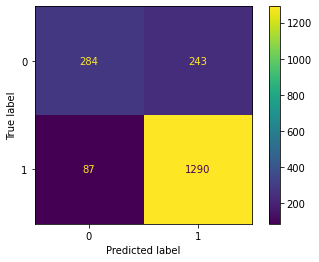

In [4]:
### Selecionar dados
X=df[['MntMeatProducts', 'MntWines']]
y=df['Dependents_Target'].values


### MinMaxScaler
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)


### Configuração do modelo
model_LP_knn = LabelPropagation(kernel='knn', '
                              n_neighbors=20, 
                              max_iter=1000, 
                              tol=0.001, 
                              n_jobs=-1, 
                             )

### Fit 
LP_knn=model_LP_knn.fit(X_scaled, y)

### Excluir dados conhecidos para testar o modelo
df_eval=df[['Dependents_Flag', 'Dependents_Target']].copy() 
df_eval['Predicted_label']=LP_knn.transduction_ 
df_eval=df_eval[df_eval['Dependents_Target']==-1] 

### Step 6 - Sumário dos resultados do modelo
print("Model Name: ", str(LP_knn))
print("Classes: ", LP_knn.classes_)
print("Label Distributions: ", LP_knn.label_distributions_)
print("Transduction Label: ", LP_knn.transduction_)
print("No. of features: ", LP_knn.n_features_in_)
print("No. of iterations: ", LP_knn.n_iter_)
print('')
print('*************** Evaluation of LP knn model ***************')
print(classification_report(df_eval['Dependents_Flag'], df_eval['Predicted_label']))
print('')
print('******************** Confusion Matrix ********************')
cm= confusion_matrix(df_eval['Dependents_Flag'], df_eval['Predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LP_knn.classes_)
disp.plot()
plt.show()